In [1]:
import wandb
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.metrics import f1_score
from wandb.lightgbm import wandb_callback, log_summary
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
wandb.login()

wandb: Currently logged in as: d-a-pop (midigpt). Use `wandb login --relogin` to force relogin


True

## Reprocess test data

In [3]:
def parse_data():
    # read and prepare data for training
    train = pd.read_csv("train.csv")
    val = pd.read_csv("val.csv")

    train['user_id'] = train['user_id'].astype("category")
    train['review_id'] = train['review_id'].astype("category")
    train['book_id'] = train['book_id'].astype("category")
    train = train.drop("review_text", axis=1)

    val['user_id'] = val['user_id'].astype("category")
    val['review_id'] = val['review_id'].astype("category")
    val['book_id'] = val['book_id'].astype("category")
    val = val.drop("review_text", axis=1)
    
    return train, val

In [4]:
def evaluate_macroF1_lgb(truth, predictions):  
    # this follows the discussion in https://github.com/Microsoft/LightGBM/issues/1483
    pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', f1, True)

In [5]:
def train(config):
    # perform one training iteration
    train, val = parse_data()
    
    model = lgb.LGBMClassifier(boosting_type=config["boosting_type"], num_leaves=config["num_leaves"], 
                               max_depth=config["max_depth"], learning_rate=config["learning_rate"], 
                               n_estimators=config["n_estimators"], min_child_samples=config["min_child_samples"], 
                               subsample=config["subsample"], colsample_bytree=config["colsample_bytree"], 
                               random_state=config["random_state"], reg_alpha=config["reg_alpha"], 
                               reg_lambda=config["reg_lambda"])
    
    train_config = model.get_params()
    print("TRAIN CONFIG")
    print(train_config)
    
    run = wandb.init(project="Goodreads Books Reviews", entity="d-a-pop", job_type="training", config=train_config)    
    
    gbm = model.fit(train.drop("rating", axis=1), train["rating"], callbacks=[wandb_callback()], \
                     categorical_feature=["user_id", "book_id", "review_id"], eval_metric=evaluate_macroF1_lgb, \
                     eval_set=[(train.drop("rating", axis=1), train["rating"]), (val.drop("rating", axis=1), val["rating"])], \
                     eval_names=["training", "validation"]);

    log_summary(gbm.booster_)
    
    if config["log_preds"]:
        ypred_ = model.predict_proba(val.drop("rating", axis=1))
        predictions = val[["review_id", "rating"]]
        predictions["pred"] = np.argmax(ypred_, axis=1)
        table = wandb.Table(dataframe=predictions)
        wandb.log({"pred_table":table})
    
    run.finish()
    


In [6]:
train, val = parse_data()

In [7]:
train.columns

Index(['user_id', 'book_id', 'review_id', 'n_votes', 'n_comments', 'rating',
       'missing_started_at', 'review_length', 'hour_read_at', 'hour_added',
       'hour_updated', 'month_read_at', 'month_added', 'month_updated',
       'dayofweek_read_at', 'dayofweek_added', 'dayofweek_updated',
       'year_read_at', 'year_added', 'year_updated', 'spoiler', 'updated',
       'update_duration', 'read_duration', 'added_at_read', 'added_at_start',
       'updated_at_read', 'duration_added_at_read', 'duration_added_at_start',
       'duration_updated_at_read'],
      dtype='object')

In [8]:
config = {"log_preds":True, "boosting_type":"gbdt", "num_leaves":41, "max_depth":-1, "learning_rate":0.1, 
     "n_estimators":300, "min_child_samples":20, "subsample":1.0, "colsample_bytree":1.0, "random_state":42, 
     "reg_alpha":0, "reg_lambda":0.01}

In [9]:
model = lgb.LGBMClassifier(boosting_type=config["boosting_type"], num_leaves=config["num_leaves"], 
                               max_depth=config["max_depth"], learning_rate=config["learning_rate"], 
                               n_estimators=config["n_estimators"], min_child_samples=config["min_child_samples"], 
                               subsample=config["subsample"], colsample_bytree=config["colsample_bytree"], 
                               random_state=config["random_state"], reg_alpha=config["reg_alpha"], 
                               reg_lambda=config["reg_lambda"])

In [10]:
train_config = model.get_params()
print("CONFIG")
print(train_config)

CONFIG
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 300, 'n_jobs': -1, 'num_leaves': 41, 'objective': None, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0.01, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [11]:
run = wandb.init(project="Goodreads Books Reviews", entity="d-a-pop", job_type="training", config=train_config)    

wandb: Currently logged in as: d-a-pop. Use `wandb login --relogin` to force relogin


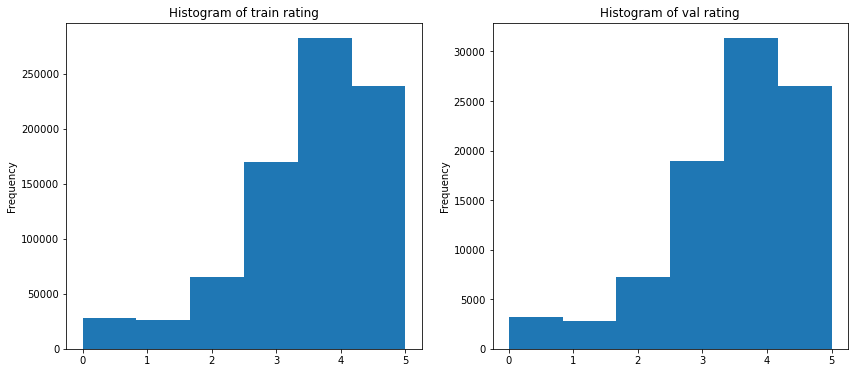

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
train['rating'].plot.hist(bins=6, title="Histogram of train rating", ax=axes[0])
val['rating'].plot.hist(bins=6, title="Histogram of val rating", ax=axes[1])

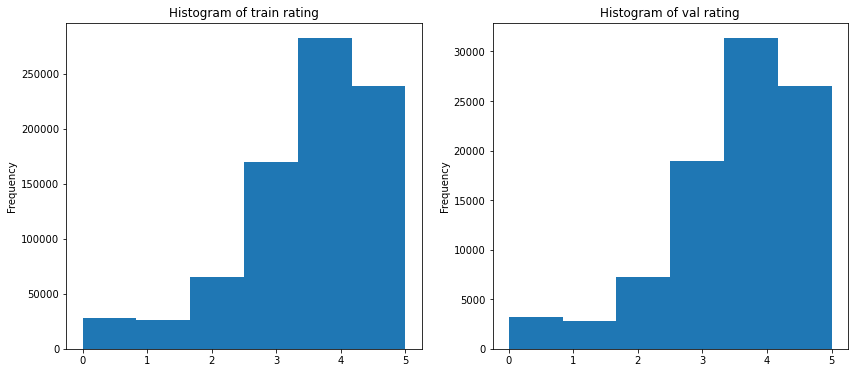

In [13]:
fig

In [14]:
f = wandb.Image(fig)

In [15]:
wandb.log({"histograms":f})

In [16]:
gbm = model.fit(train.drop("rating", axis=1), train["rating"], callbacks=[wandb_callback()], \
                 categorical_feature=["user_id", "book_id", "review_id"], eval_metric=evaluate_macroF1_lgb, \
                 eval_set=[(train.drop("rating", axis=1), train["rating"]), (val.drop("rating", axis=1), val["rating"])], \
                 eval_names=["training", "validation"]);


/Users/dragos/anaconda3/envs/lgbm/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/dragos/anaconda3/envs/lgbm/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['book_id', 'review_id', 'user_id']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
/Users/dragos/anaconda3/envs/lgbm/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/dragos/anaconda3/envs/lgbm/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[1]	training's multi_logloss: 1.43777	training's macroF1: 0.13197	validation's multi_logloss: 1.43742	validation's macroF1: 0.128805
[2]	training's multi_logloss: 1.413	training's macroF1: 0.179453	validation's multi_logloss: 1.41626	validation's macroF1: 0.173828
[3]	training's multi_logloss: 1.3942	training's macroF1: 0.201963	validation's multi_logloss: 1.40039	validation's macroF1: 0.192632
[4]	training's multi_logloss: 1.37848	training's macroF1: 0.218282	validation's multi_logloss: 1.38768	validation's macroF1: 0.206907
[5]	training's multi_logloss: 1.36474	training's macroF1: 0.24253	validation's multi_logloss: 1.37642	validation's macroF1: 0.24176
[6]	training's multi_logloss: 1.35337	training's macroF1: 0.259152	validation's multi_logloss: 1.36773	validation's macroF1: 0.252373
[7]	training's multi_logloss: 1.34305	training's macroF1: 0.270527	validation's multi_logloss: 1.36097	validation's macroF1: 0.259668
[8]	training's multi_logloss: 1.33375	training's macroF1: 0.280347	v

[62]	training's multi_logloss: 1.14039	training's macroF1: 0.462003	validation's multi_logloss: 1.25193	validation's macroF1: 0.367791
[63]	training's multi_logloss: 1.13865	training's macroF1: 0.463457	validation's multi_logloss: 1.25136	validation's macroF1: 0.368376
[64]	training's multi_logloss: 1.13698	training's macroF1: 0.464825	validation's multi_logloss: 1.2507	validation's macroF1: 0.369024
[65]	training's multi_logloss: 1.13528	training's macroF1: 0.466186	validation's multi_logloss: 1.25012	validation's macroF1: 0.370167
[66]	training's multi_logloss: 1.13368	training's macroF1: 0.467637	validation's multi_logloss: 1.24954	validation's macroF1: 0.369942
[67]	training's multi_logloss: 1.13218	training's macroF1: 0.468953	validation's multi_logloss: 1.24906	validation's macroF1: 0.370709
[68]	training's multi_logloss: 1.13035	training's macroF1: 0.470562	validation's multi_logloss: 1.24867	validation's macroF1: 0.371261
[69]	training's multi_logloss: 1.12854	training's macroF

[123]	training's multi_logloss: 1.05994	training's macroF1: 0.530956	validation's multi_logloss: 1.23276	validation's macroF1: 0.392469
[124]	training's multi_logloss: 1.05893	training's macroF1: 0.531871	validation's multi_logloss: 1.23265	validation's macroF1: 0.392634
[125]	training's multi_logloss: 1.05794	training's macroF1: 0.532866	validation's multi_logloss: 1.23248	validation's macroF1: 0.392338
[126]	training's multi_logloss: 1.05712	training's macroF1: 0.533634	validation's multi_logloss: 1.23229	validation's macroF1: 0.392533
[127]	training's multi_logloss: 1.05612	training's macroF1: 0.534489	validation's multi_logloss: 1.23227	validation's macroF1: 0.392605
[128]	training's multi_logloss: 1.0552	training's macroF1: 0.535175	validation's multi_logloss: 1.2321	validation's macroF1: 0.392845
[129]	training's multi_logloss: 1.0541	training's macroF1: 0.536218	validation's multi_logloss: 1.23202	validation's macroF1: 0.392749
[130]	training's multi_logloss: 1.05328	training's 

[184]	training's multi_logloss: 1.00782	training's macroF1: 0.57381	validation's multi_logloss: 1.22924	validation's macroF1: 0.398652
[185]	training's multi_logloss: 1.00682	training's macroF1: 0.574718	validation's multi_logloss: 1.2292	validation's macroF1: 0.398375
[186]	training's multi_logloss: 1.00613	training's macroF1: 0.575348	validation's multi_logloss: 1.22916	validation's macroF1: 0.398887
[187]	training's multi_logloss: 1.00529	training's macroF1: 0.575921	validation's multi_logloss: 1.22911	validation's macroF1: 0.398832
[188]	training's multi_logloss: 1.00463	training's macroF1: 0.576557	validation's multi_logloss: 1.22907	validation's macroF1: 0.398957
[189]	training's multi_logloss: 1.00383	training's macroF1: 0.577203	validation's multi_logloss: 1.22913	validation's macroF1: 0.399368
[190]	training's multi_logloss: 1.00311	training's macroF1: 0.577653	validation's multi_logloss: 1.22914	validation's macroF1: 0.399456
[191]	training's multi_logloss: 1.00258	training's

[245]	training's multi_logloss: 0.966217	training's macroF1: 0.606624	validation's multi_logloss: 1.23069	validation's macroF1: 0.402153
[246]	training's multi_logloss: 0.965559	training's macroF1: 0.607071	validation's multi_logloss: 1.23067	validation's macroF1: 0.402473
[247]	training's multi_logloss: 0.964883	training's macroF1: 0.607686	validation's multi_logloss: 1.23066	validation's macroF1: 0.402454
[248]	training's multi_logloss: 0.964261	training's macroF1: 0.60828	validation's multi_logloss: 1.23065	validation's macroF1: 0.402537
[249]	training's multi_logloss: 0.963599	training's macroF1: 0.608726	validation's multi_logloss: 1.23066	validation's macroF1: 0.402672
[250]	training's multi_logloss: 0.962839	training's macroF1: 0.609341	validation's multi_logloss: 1.23071	validation's macroF1: 0.402639
[251]	training's multi_logloss: 0.962403	training's macroF1: 0.609678	validation's multi_logloss: 1.23076	validation's macroF1: 0.402626
[252]	training's multi_logloss: 0.961812	t

In [17]:
log_summary(gbm.booster_)

In [18]:
ypred_ = model.predict_proba(val.drop("rating", axis=1))
predictions = val[["review_id", "rating"]]
predictions["pred"] = np.argmax(ypred_, axis=1)
table = wandb.Table(dataframe=predictions)
wandb.log({"pred_table":table})

<ipython-input-18-1f66504940d7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions["pred"] = np.argmax(ypred_, axis=1)


In [19]:
mat = confusion_matrix(val["rating"], predictions["pred"])
print(mat)

[[ 1885    72    86   206   552   375]
 [  117   460   434   615   699   431]
 [  108   303   885  2373  2692   870]
 [  171   280   887  5777  9222  2636]
 [  278   203   619  4834 17999  7402]
 [  259   174   318  1513  9014 15251]]


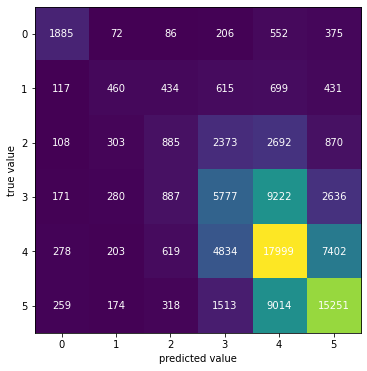

In [20]:
classes = [0, 1, 2, 3, 4, 5]

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(mat, cmap='viridis', interpolation='nearest')
ax.set_xlabel('predicted value')
ax.set_ylabel('true value')
ax.set_xticks([0,1,2,3,4,5])
ax.set_yticks([0,1,2,3,4,5])
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
ax.tick_params(axis='both', which='major')

for i in range(len(mat)):
    for j in range(len(mat)):
        text = ax.text(j, i, mat[i, j],
                       ha="center", va="center", color="w")

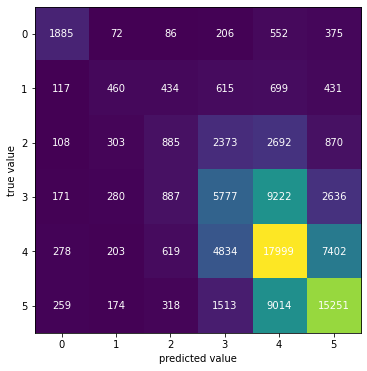

In [21]:
fig

In [22]:
f = wandb.Image(fig)

In [23]:
wandb.log({"confusion_matrix":f})

In [24]:
model.booster_.save_model('model.txt')

In [25]:
art = wandb.Artifact("lgbm", type="model")
art.add_file("model.txt")
wandb.log_artifact(art)

In [26]:
run.finish()

iteration,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
training_macroF1,▁▂▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
training_multi_logloss,█▇▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
validation_macroF1,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇████████████████████████
validation_multi_logloss,█▇▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_iteration,0
iteration,299
training_macroF1,0.62974
validation_macroF1,0.40421


In [194]:
# rerun the processing on the original test data
test = pd.read_csv("goodreads_test.csv")

In [195]:
test.isna().sum()

user_id              0
book_id              0
review_id            0
review_text          0
date_added           0
date_updated         0
read_at          42478
started_at      143044
n_votes              0
n_comments           0
dtype: int64

In [196]:
test["n_votes"] = abs(test["n_votes"])
test["n_comments"] = abs(test["n_comments"])

In [197]:
test['user_id'] = test['user_id'].astype("category")
test['review_id'] = test['review_id'].astype("category")
test['book_id'] = test['book_id'].astype("category")

In [198]:
test['date_added'] = pd.to_datetime(test['date_added'], format="%a %b %d %H:%M:%S %z %Y")
test['date_updated'] = pd.to_datetime(test['date_updated'], format="%a %b %d %H:%M:%S %z %Y")

In [199]:
test['read_at'].fillna(test['date_added'], inplace=True)

In [200]:
test['read_at'] = pd.to_datetime(test['read_at'], format="%a %b %d %H:%M:%S %z %Y", errors = 'coerce')

In [201]:
test["read_at"] = test["read_at"].fillna(value=np.nan)

In [202]:
# read_at has missing values
test["read_at"].isna().sum()

42484

In [203]:
test['read_at'].fillna(test['read_at'].mode()[0], inplace=True)

In [204]:
test["read_at"].isna().sum()

0

In [205]:
test["missing_started_at"] = test["started_at"].isna().astype(int)


In [206]:
test['started_at'] = pd.to_datetime(test['started_at'], format="%a %b %d %H:%M:%S %z %Y", errors = 'coerce')  

In [207]:
test["started_at"].isna().sum()

143050

In [210]:
m = pd.Timedelta('9 days 01:43:15.207681802')

In [211]:
test["started_at"].fillna(test["read_at"]-m, inplace=True)

In [212]:
test["started_at"].isna().sum()

0

In [214]:
test.isna().sum()

user_id               0
book_id               0
review_id             0
review_text           0
date_added            0
date_updated          0
read_at               0
started_at            0
n_votes               0
n_comments            0
missing_started_at    0
dtype: int64

In [215]:
test["review_length"] = test["review_text"].apply(lambda n: len(n.split()))
test["hour_read_at"] = test["read_at"].apply(lambda x: x.hour)
test["hour_added"] = test["date_added"].apply(lambda x: x.hour)
test["hour_updated"] = test["date_updated"].apply(lambda x: x.hour)
test["month_read_at"] = test["read_at"].apply(lambda x: x.month)
test["month_added"] = test["date_added"].apply(lambda x: x.month)
test["month_updated"] = test["date_updated"].apply(lambda x: x.month)
test["dayofweek_read_at"] = test["read_at"].apply(lambda x: x.dayofweek)
test["dayofweek_added"] = test["date_added"].apply(lambda x: x.dayofweek)
test["dayofweek_updated"] = test["date_updated"].apply(lambda x: x.dayofweek)
test["year_read_at"] = test["read_at"].apply(lambda x: x.year)
test["year_added"] = test["date_added"].apply(lambda x: x.year)
test["year_updated"] = test["date_updated"].apply(lambda x: x.year)

In [216]:
test['spoiler'] = test["review_text"].str.contains("\** spoiler alert \**", case=True, na=False).astype(int)

In [217]:
test["updated"] = (test["date_updated"] == test["date_added"]).astype(int)

In [223]:
test["date_updated_"] = pd.to_datetime(test['date_updated'], utc=True)
test["date_added_"] = pd.to_datetime(test['date_added'], utc=True)

In [224]:
test["update_duration"] = test['date_updated_'].dt.tz_convert(None) - test['date_added_'].dt.tz_convert(None)

In [227]:
test["read_at_"] = pd.to_datetime(test['read_at'], utc=True)
test["started_at_"] = pd.to_datetime(test['started_at'], utc=True)
test["read_duration"] = test["read_at_"] - test["started_at_"]


In [237]:
test["added_at_read"] = (test["read_at"] == test["date_added"]).astype(int)
test["duration_added_at_read"] = test["read_at_"] - test["date_added_"]
test["added_at_start"] = (test["started_at"] == test["date_added"]).astype(int)
test["duration_added_at_start"] = test["started_at_"] - test["date_added_"]
test["updated_at_read"] = (test["read_at"] == test["date_updated"]).astype(int)
test["duration_updated_at_read"] = test["read_at_"] - test["date_updated_"]
test["duration_updated_at_read"] = test["duration_updated_at_read"].astype(int)/ 10**9
test["duration_added_at_start"] = test["duration_added_at_start"].astype(int)/ 10**9
test["duration_added_at_read"] = test["duration_added_at_read"].astype(int)/ 10**9
test["read_duration"] = test["read_duration"].astype(int)/ 10**9
test["update_duration"] = test["update_duration"].astype(int)/ 10**9

In [244]:
train.columns

Index(['user_id', 'book_id', 'review_id', 'n_votes', 'n_comments', 'rating',
       'missing_started_at', 'review_length', 'hour_read_at', 'hour_added',
       'hour_updated', 'month_read_at', 'month_added', 'month_updated',
       'dayofweek_read_at', 'dayofweek_added', 'dayofweek_updated',
       'year_read_at', 'year_added', 'year_updated', 'spoiler', 'updated',
       'update_duration', 'read_duration', 'added_at_read', 'added_at_start',
       'updated_at_read', 'duration_added_at_read', 'duration_added_at_start',
       'duration_updated_at_read'],
      dtype='object')

In [245]:
test.columns

Index(['user_id', 'book_id', 'review_id', 'n_votes', 'n_comments',
       'missing_started_at', 'review_length', 'hour_read_at', 'hour_added',
       'hour_updated', 'month_read_at', 'month_added', 'month_updated',
       'dayofweek_read_at', 'dayofweek_added', 'dayofweek_updated',
       'year_read_at', 'year_added', 'year_updated', 'spoiler', 'updated',
       'update_duration', 'read_duration', 'added_at_read',
       'duration_added_at_read', 'added_at_start', 'duration_added_at_start',
       'updated_at_read', 'duration_updated_at_read'],
      dtype='object')

In [242]:
test = test.drop(['date_added', 'date_updated', 'read_at', 'started_at', 'read_at_', 'started_at_', 'date_updated_',
                 'date_added_'], axis = 1)

In [243]:
test = test.drop("review_text", axis=1)

In [246]:
# predict
p = model.predict_proba(test)
s = pd.Series(np.argmax(p, axis=1))
len(s)

478033

In [247]:
len(test)

478033

In [249]:
r = test["review_id"]
submission = pd.concat([r,s],axis=1).rename(columns={0: "rating"})
submission

,review_id,rating
0,5c4df7e70e9b438c761f07a4620ccb7c,4
1,8eaeaf13213eeb16ad879a2a2591bbe5,3
2,dce649b733c153ba5363a0413cac988f,4
3,8a46df0bb997269d6834f9437a4b0a77,4
4,d11d3091e22f1cf3cb865598de197599,3
...,...,...
478028,0e1db3d4b04256f9660f5d276ddf1314,5
478029,0b7f352e58caf0fd1f961e98ef04e89c,4
478030,9b19eff33ddb14e9e68fca2e90379e46,5
478031,8be463fed78f0da63e964706f710332b,5


In [250]:
submission.to_csv("sub7.csv", index=False)

## Submission

In [19]:
test = pd.read_csv("test.csv")
r = test["review_id"]
test['user_id'] = test['user_id'].astype("category")
test['review_id'] = test['review_id'].astype("category")
test['book_id'] = test['book_id'].astype("category")
test = test.drop("review_text", axis=1)

In [20]:
p = model.predict_proba(test)
s = pd.Series(np.argmax(p, axis=1))
len(s)

478033

In [21]:
len(test)

478033

In [22]:
submission = pd.concat([r,s],axis=1).rename(columns={0: "rating"})
submission

,review_id,rating
0,5c4df7e70e9b438c761f07a4620ccb7c,4
1,8eaeaf13213eeb16ad879a2a2591bbe5,3
2,dce649b733c153ba5363a0413cac988f,4
3,8a46df0bb997269d6834f9437a4b0a77,4
4,d11d3091e22f1cf3cb865598de197599,3
...,...,...
478028,0e1db3d4b04256f9660f5d276ddf1314,5
478029,0b7f352e58caf0fd1f961e98ef04e89c,0
478030,9b19eff33ddb14e9e68fca2e90379e46,5
478031,8be463fed78f0da63e964706f710332b,5


In [23]:
submission.to_csv("sub5.csv", index=False)

## Train on train and val sets

In [24]:
train, val = parse_data()

In [26]:
len(val)

90000

In [27]:
df = pd.concat([train, val])

In [30]:
len(df)

900000

In [37]:
df['user_id'] = df['user_id'].astype("category")
df['review_id'] = df['review_id'].astype("category")
df['book_id'] = df['book_id'].astype("category")

In [38]:
config = {"log_preds":True, "boosting_type":"gbdt", "num_leaves":41, "max_depth":-1, "learning_rate":0.1, 
     "n_estimators":300, "min_child_samples":20, "subsample":1.0, "colsample_bytree":1.0, "random_state":42, 
     "reg_alpha":0, "reg_lambda":0.01}

In [39]:
model1 = lgb.LGBMClassifier(boosting_type=config["boosting_type"], num_leaves=config["num_leaves"], 
                               max_depth=config["max_depth"], learning_rate=config["learning_rate"], 
                               n_estimators=config["n_estimators"], min_child_samples=config["min_child_samples"], 
                               subsample=config["subsample"], colsample_bytree=config["colsample_bytree"], 
                               random_state=config["random_state"], reg_alpha=config["reg_alpha"], 
                               reg_lambda=config["reg_lambda"])

In [40]:
run = wandb.init(project="Goodreads Books Reviews", entity="d-a-pop", job_type="training", config=train_config)    

In [41]:
train_config = model1.get_params()
print("TRAIN CONFIG")
print(train_config)

TRAIN CONFIG
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 300, 'n_jobs': -1, 'num_leaves': 41, 'objective': None, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0.01, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [42]:
gbm = model1.fit(df.drop("rating", axis=1), df["rating"], callbacks=[wandb_callback()], \
                 categorical_feature=["user_id", "book_id", "review_id"], eval_metric=evaluate_macroF1_lgb)

In [43]:
log_summary(gbm.booster_)

In [44]:
run.finish()

iteration,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
best_iteration,0
iteration,299


In [45]:
test = pd.read_csv("test.csv")
r = test["review_id"]
test['user_id'] = test['user_id'].astype("category")
test['review_id'] = test['review_id'].astype("category")
test['book_id'] = test['book_id'].astype("category")
test = test.drop("review_text", axis=1)

In [46]:
p = model1.predict_proba(test)
s = pd.Series(np.argmax(p, axis=1))
len(s)

478033

In [47]:
len(test)

478033

In [48]:
submission = pd.concat([r,s],axis=1).rename(columns={0: "rating"})
submission

,review_id,rating
0,5c4df7e70e9b438c761f07a4620ccb7c,4
1,8eaeaf13213eeb16ad879a2a2591bbe5,3
2,dce649b733c153ba5363a0413cac988f,4
3,8a46df0bb997269d6834f9437a4b0a77,4
4,d11d3091e22f1cf3cb865598de197599,3
...,...,...
478028,0e1db3d4b04256f9660f5d276ddf1314,5
478029,0b7f352e58caf0fd1f961e98ef04e89c,0
478030,9b19eff33ddb14e9e68fca2e90379e46,5
478031,8be463fed78f0da63e964706f710332b,5


In [49]:
submission.to_csv("sub6.csv", index=False)